<a href="https://colab.research.google.com/github/nandhukumar86/CapstonePneumoniaDetection/blob/main/DenseNet_TransferLearning_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import skimage.io as io
import os
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, ReLU, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, Concatenate, Reshape, UpSampling2D
import pickle
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
import gc
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras.applications import VGG16
from google.colab.patches import cv2_imshow
from tensorflow import reduce_sum
from tensorflow.keras.backend import log,epsilon
from keras import backend as K
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1])
  union = K.sum(y_true, axis=[1]) + K.sum(y_pred, axis=[1])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

# def iou_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
#   union = K.sum(y_true,[1])+K.sum(y_pred,[1])-intersection
#   iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#   return iou

# def loss(y_true, y_pred):
#   return binary_crossentropy(y_true, y_pred) - log(iou_coef(y_true, y_pred))


# def dice_coefficient(y_true, y_pred):
#     numerator = 2 * reduce_sum(y_true * y_pred)
#     denominator = reduce_sum(y_true + y_pred)
#     return numerator / (denominator + epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coef(y_true, y_pred) + epsilon())

In [4]:
file = open('/content/drive/MyDrive/CapstoneDataSet/dataset/RezisedLabel-1.pickle', 'rb')
dfData = pickle.load(file)
file.close()

In [5]:
dfData_0 = dfData[dfData['Target'] == 0].sample(9555)
dfData_1 = dfData[dfData['Target'] == 1].sample(9555)

In [6]:
dfData = pd.concat([dfData_0, dfData_1], axis=0, ignore_index=True)

In [7]:
dfData = dfData.sample(frac=1)

In [8]:
y = []
X = []
i = 0
for pId in dfData['patientId'].unique():
  data = dfData[dfData['patientId'] == pId][['Image256','xo','yo','widtho','heighto','Target']]
  X.append(cv2.cvtColor(cv2.resize(data.iloc[0][0],(256,256)), cv2.COLOR_BAYER_GR2RGB))
  mask = np.zeros((256,256))
  if (data.iloc[0][5] == 1):
    j = 0
    for segment in range(data.shape[0]):
      xo = int(data.iloc[j][1])
      yo = int(data.iloc[j][2])
      wo = int(data.iloc[j][1] + data.iloc[j][3])
      ho = int(data.iloc[j][2] + data.iloc[j][4])
      mask = cv2.rectangle(mask,(xo, yo),(wo, ho),(255,0,0),-1)
      # mask = cv2.resize(mask,(256,256))
      j = j+1
  y.append(cv2.resize(mask,(64,64)))
  if (i%1000 == 0):
    print(i, " completed")
  i = i + 1

0  completed
1000  completed
2000  completed
3000  completed
4000  completed
5000  completed
6000  completed
7000  completed
8000  completed
9000  completed
10000  completed
11000  completed
12000  completed
13000  completed
14000  completed
15000  completed


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=48)

In [10]:
tensorflow.keras.backend.clear_session()

In [11]:
gc.collect()

286

In [12]:
model = DenseNet121(input_shape=(256,256,3),include_top=False,weights='imagenet')

In [13]:
lengthLayers = len(model.layers)
pcLayers = int(0.8 * lengthLayers)
for i in range(pcLayers):
  model.layers[i].trainable = False
  

In [14]:
layer8x8 = model.get_layer('conv5_block16_2_conv').output
layer16x16 = model.get_layer('conv4_block24_2_conv').output
layer32x32 = model.get_layer('conv3_block12_2_conv').output
layer64x64 = model.get_layer('conv2_block6_2_conv').output

yy = Concatenate()([UpSampling2D()(layer8x8), layer16x16])
yy = Concatenate()([UpSampling2D()(yy), layer32x32])
yy = Concatenate()([UpSampling2D()(yy), layer64x64])

yy = Conv2D(1, kernel_size = 1,activation='relu')(yy)
yy = Reshape((64, 64))(yy)


model_segments = Model(model.input, yy)

In [15]:
gc.collect()

1631

In [16]:
X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

In [17]:
y_val = np.array(y_val)/255
y_train = np.array(y_train)/255

In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10896, 256, 256, 3), (10896, 64, 64), (4671, 256, 256, 3), (4671, 64, 64))

In [19]:
gc.collect()

200

In [20]:
model_segments.compile(loss=tensorflow.keras.losses.CosineSimilarity(), 
                       optimizer='adam', 
                       metrics=['mse'])

# earlystop_segments = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, min_delta=0.01)

model_segments.fit(X_train, y_train, 
                     epochs=20, batch_size=16, 
                     validation_data=(X_val, y_val), 
                    #  callbacks = [earlystop_segments],
                     verbose=1) 


Epoch 1/20
681/681 [==============================] - 55s 67ms/step - loss: -0.1072 - mse: 1.0969 - val_loss: -0.1078 - val_mse: 1.5525
Epoch 2/20
681/681 [==============================] - 43s 63ms/step - loss: -0.1110 - mse: 0.6342 - val_loss: -0.1090 - val_mse: 0.2545
Epoch 3/20
681/681 [==============================] - 43s 63ms/step - loss: -0.1135 - mse: 0.1630 - val_loss: -0.1095 - val_mse: 0.1298
Epoch 4/20
681/681 [==============================] - 43s 63ms/step - loss: -0.1158 - mse: 0.0940 - val_loss: -0.1094 - val_mse: 0.0736
Epoch 5/20
681/681 [==============================] - 43s 63ms/step - loss: -0.1178 - mse: 0.0700 - val_loss: -0.1083 - val_mse: 0.0686
Epoch 6/20
681/681 [==============================] - 43s 63ms/step - loss: -0.1195 - mse: 0.0580 - val_loss: -0.1089 - val_mse: 0.0707
Epoch 7/20
681/681 [==============================] - 43s 63ms/step - loss: -0.1208 - mse: 0.0514 - val_loss: -0.1082 - val_mse: 0.0494
Epoch 8/20
681/681 [============================

In [49]:
gc.collect()

1970

In [35]:
! pip install tensorflowjs

     |████████████████████████████████| 71kB 3.2MB/s 


In [36]:
import tensorflowjs
tensorflowjs.converters.save_keras_model(model_segments,'/content/drive/MyDrive/CapstoneDataSet/segmentModel')

In [ ]:
gc.collect()

120

In [21]:
y_test_predict = model_segments.predict(X_train)

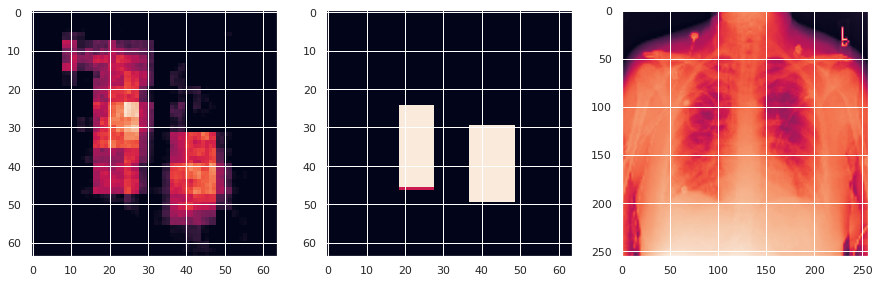

In [34]:
n = int(np.random.rand(1)[0]*X_train.shape[0])

fig, axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(y_test_predict[n].reshape(64,64))
axes[1].imshow(y_train[n]);
axes[2].imshow(X_train[n][:,:,0])

In [119]:
y_test_predict[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [63]:
np.round(y_test_predict[n][20:25,20:25])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

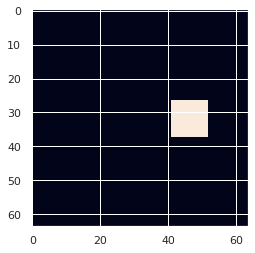

In [104]:
plt.imshow(y_train[0])